# UEFA's Away Goals Rule

I recently read [UEFAs explanation](https://www.uefa.com/uefachampionsleague/news/0295-1cd662315a16-d45212883270-1000--away-goals-rule-why-uefa-scrapped-it-for-the-champions-lea/) for abolishing the away goals rule. It made me curious to take a data driven approach to verify whether the arguments they provided are actually reflected in historical match data from the introduction of the rule up to its removal. Even though the decision was made a few years ago, I still want to explore the topic from a statistical perspective.

As a first step, I want to examine one of UEFA’s central claims: that the team playing the second leg away enjoyed a structural advantage because of how the away goals rule was applied. My goal is to test whether this advantage is observable in the data.

To have a bigger datasize I include also games from the European Cup area. Same as UEFA does.

**Convention:**
- Team A = home in the first leg, away in the second leg.
- Team B = away in the first leg, home in the second leg.

In extra time of the second leg, Team A is the away team and therefore has the additional potential away goal period.

In [1]:
import pandas as pd

DATA_PATH = "../data/matches.csv"

df = pd.read_csv(DATA_PATH)
df["season_start"] = df["season"].str.split("-").str[0].astype(int)
df.head()


,season,match_id,match_name,status,match_type,phase,mode,mode_detail,secondary_type,round,...,et1,et2,pen1,pen2,t2,t2_name,stadium,attendance,related_matches,season_start
0,1988-1989,54,2 - 1st,FINISHED,SECOND_LEG,TOURNAMENT,KNOCK_OUT,KNOCK_OUT_TWO_LEGS,NaN,FIRST,...,4.0,0.0,NaN,NaN,50054,Budapest Honvéd FC,63524.0,42763.0,53,1988
1,1988-1989,48,2 - 1st,FINISHED,SECOND_LEG,TOURNAMENT,KNOCK_OUT,KNOCK_OUT_TWO_LEGS,NaN,FIRST,...,5.0,2.0,NaN,NaN,50044,PFC Levski Sofia,57771.0,53086.0,47,1988
2,1988-1989,159,2 - 1st,FINISHED,SECOND_LEG,TOURNAMENT,KNOCK_OUT,KNOCK_OUT_TWO_LEGS,NaN,FIRST,...,5.0,0.0,NaN,NaN,50039,Berliner FC Dynamo,62853.0,23542.0,158,1988
3,1988-1989,313,1 - 2nd,FINISHED,FIRST_LEG,TOURNAMENT,KNOCK_OUT,KNOCK_OUT_TWO_LEGS,NaN,SECOND,...,3.0,0.0,NaN,NaN,50068,FC Spartak Moskva,62423.0,27000.0,314,1988
4,1988-1989,315,1 - 2nd,FINISHED,FIRST_LEG,TOURNAMENT,KNOCK_OUT,KNOCK_OUT_TWO_LEGS,NaN,SECOND,...,0.0,3.0,NaN,NaN,50066,IFK Göteborg,63266.0,20000.0,316,1988


In [2]:
# Seasons where the away goals rule was in effect in the UEFA Champions League
mask_season = (df["season_start"] >= 1965) & (df["season_start"] <= 2020)

# Two legged knockout ties in the main tournament phase
mask_two_leg = df["mode_detail"] == "KNOCK_OUT_TWO_LEGS"
mask_leg_type = df["match_type"].isin(["FIRST_LEG", "SECOND_LEG"])
mask_tournament = df["phase"] == "TOURNAMENT"

df_rule = df[mask_season & mask_two_leg & mask_leg_type & mask_tournament].copy()
print("Matches in away goals context:", len(df_rule))
df_rule.head()


Matches in away goals context: 2245


,season,match_id,match_name,status,match_type,phase,mode,mode_detail,secondary_type,round,...,et1,et2,pen1,pen2,t2,t2_name,stadium,attendance,related_matches,season_start
0,1988-1989,54,2 - 1st,FINISHED,SECOND_LEG,TOURNAMENT,KNOCK_OUT,KNOCK_OUT_TWO_LEGS,NaN,FIRST,...,4.0,0.0,NaN,NaN,50054,Budapest Honvéd FC,63524.0,42763.0,53,1988
1,1988-1989,48,2 - 1st,FINISHED,SECOND_LEG,TOURNAMENT,KNOCK_OUT,KNOCK_OUT_TWO_LEGS,NaN,FIRST,...,5.0,2.0,NaN,NaN,50044,PFC Levski Sofia,57771.0,53086.0,47,1988
2,1988-1989,159,2 - 1st,FINISHED,SECOND_LEG,TOURNAMENT,KNOCK_OUT,KNOCK_OUT_TWO_LEGS,NaN,FIRST,...,5.0,0.0,NaN,NaN,50039,Berliner FC Dynamo,62853.0,23542.0,158,1988
3,1988-1989,313,1 - 2nd,FINISHED,FIRST_LEG,TOURNAMENT,KNOCK_OUT,KNOCK_OUT_TWO_LEGS,NaN,SECOND,...,3.0,0.0,NaN,NaN,50068,FC Spartak Moskva,62423.0,27000.0,314,1988
4,1988-1989,315,1 - 2nd,FINISHED,FIRST_LEG,TOURNAMENT,KNOCK_OUT,KNOCK_OUT_TWO_LEGS,NaN,SECOND,...,0.0,3.0,NaN,NaN,50066,IFK Göteborg,63266.0,20000.0,316,1988


In [3]:
df_pairs = df_rule.copy()

# Ensure numeric IDs
df_pairs["match_id"] = df_pairs["match_id"].astype(int)
df_pairs["related_matches"] = df_pairs["related_matches"].astype("Int64")

# Drop matches that are not paired
df_pairs = df_pairs.dropna(subset=["related_matches"])

# Tie identifier
df_pairs["tie_id"] = df_pairs[["match_id", "related_matches"]].min(axis=1)

# Keep ties that have exactly two legs
df_pairs = df_pairs.groupby("tie_id").filter(lambda g: len(g) == 2)

# Mark first / second leg
df_pairs["leg_flag"] = df_pairs["match_type"].map({
    "FIRST_LEG": "first",
    "SECOND_LEG": "second",
})

first = df_pairs[df_pairs["leg_flag"] == "first"].copy()
second = df_pairs[df_pairs["leg_flag"] == "second"].copy()

# Merge legs into one row per tie
ties = first.merge(second, on="tie_id", suffixes=("_first", "_second")).reset_index(drop=True)

# Only finished ties
finished = ties[
    (ties["status_first"] == "FINISHED") &
    (ties["status_second"] == "FINISHED")
].copy()

print("Two leg ties:", finished["tie_id"].nunique())
finished[["tie_id", "season_first", "round_first", "t1_name_first", "t2_name_first"]].head()


Two leg ties: 1112


,tie_id,season_first,round_first,t1_name_first,t2_name_first
0,313,1988-1989,SECOND,FCSB,FC Spartak Moskva
1,315,1988-1989,SECOND,KF Tirana,IFK Göteborg
2,319,1988-1989,SECOND,Górnik Zabrze,Real Madrid CF
3,311,1988-1989,SECOND,PSV Eindhoven,FC Porto
4,303,1988-1989,SECOND,Neuchâtel Xamax FC,Galatasaray AŞ


In [4]:
# Fill missing score related values with 0
score_cols = [
    "ft1_first", "ft2_first", "ft1_second", "ft2_second",
    "et1_first", "et2_first", "et1_second", "et2_second",
    "pen1_second", "pen2_second",
]
for c in score_cols:
    if c in finished.columns:
        finished[c] = finished[c].fillna(0)


def state_after_180(row):
    """
    Evaluate the tie after 90+90 minutes (no extra time), applying the away goals rule.

    Team A: home in first leg, away in second.
    Team B: away in first leg, home in second.
    """
    # 90 minute scores
    A1_90 = row["ft1_first"]    # A home
    B1_90 = row["ft2_first"]    # B away

    B2_90 = row["ft1_second"]   # B home
    A2_90 = row["ft2_second"]   # A away

    aggA_90 = A1_90 + A2_90
    aggB_90 = B1_90 + B2_90

    awayA_90 = A2_90           # As away goals
    awayB_90 = B1_90           # Bs away goals

    if aggA_90 > aggB_90:
        state = "A_leads"
    elif aggB_90 > aggA_90:
        state = "B_leads"
    else:
        if awayA_90 > awayB_90:
            state = "A_leads_away"
        elif awayB_90 > awayA_90:
            state = "B_leads_away"
        else:
            state = "tied_needs_ET"

    return pd.Series({
        "state_90": state,
        "aggA_90": aggA_90,
        "aggB_90": aggB_90,
        "awayA_90": awayA_90,
        "awayB_90": awayB_90,
    })


def winner_after_120(row):
    """
    Evaluate the actual winner under the away goals rule, including extra time and penalties.

    Uses final scores after extra time and penalties taken in the second leg.
    """
    # Scores after extra time
    A1_120 = row["et1_first"]
    B1_120 = row["et2_first"]
    B2_120 = row["et1_second"]
    A2_120 = row["et2_second"]

    aggA_120 = A1_120 + A2_120
    aggB_120 = B1_120 + B2_120

    awayA_120 = A2_120
    awayB_120 = B1_120

    decided_by_away = False
    decided_by_pens = False

    if aggA_120 > aggB_120:
        winner = "A"
    elif aggB_120 > aggA_120:
        winner = "B"
    else:
        # Away goals tiebreak
        if awayA_120 > awayB_120:
            winner = "A"
            decided_by_away = True
        elif awayB_120 > awayA_120:
            winner = "B"
            decided_by_away = True
        else:
            # Penalties in 2nd leg
            pen1 = row["pen1_second"]  # B (home 2nd leg)
            pen2 = row["pen2_second"]  # A (away 2nd leg)
            if pen1 > pen2:
                winner = "B"
                decided_by_pens = True
            elif pen2 > pen1:
                winner = "A"
                decided_by_pens = True
            else:
                winner = "unknown"

    return pd.Series({
        "winner_120": winner,
        "decided_by_away_120": decided_by_away,
        "decided_by_pens_120": decided_by_pens,
        "aggA_120": aggA_120,
        "aggB_120": aggB_120,
        "awayA_120": awayA_120,
        "awayB_120": awayB_120,
    })


analysis = pd.concat(
    [
        finished[["tie_id", "season_first", "round_first", "t1_name_first", "t2_name_first"]],
        finished.apply(state_after_180, axis=1),
        finished.apply(winner_after_120, axis=1),
    ],
    axis=1,
)

analysis.head()

,tie_id,season_first,round_first,t1_name_first,t2_name_first,state_90,aggA_90,aggB_90,awayA_90,awayB_90,winner_120,decided_by_away_120,decided_by_pens_120,aggA_120,aggB_120,awayA_120,awayB_120
0,313,1988-1989,SECOND,FCSB,FC Spartak Moskva,A_leads,5.0,1.0,2.0,0.0,A,False,False,5.0,1.0,2.0,0.0
1,315,1988-1989,SECOND,KF Tirana,IFK Göteborg,B_leads,0.0,4.0,0.0,3.0,B,False,False,0.0,4.0,0.0,3.0
2,319,1988-1989,SECOND,Górnik Zabrze,Real Madrid CF,B_leads,2.0,4.0,2.0,1.0,B,False,False,2.0,4.0,2.0,1.0
3,311,1988-1989,SECOND,PSV Eindhoven,FC Porto,A_leads,5.0,2.0,0.0,0.0,A,False,False,5.0,2.0,0.0,0.0
4,303,1988-1989,SECOND,Neuchâtel Xamax FC,Galatasaray AŞ,B_leads,3.0,5.0,0.0,0.0,B,False,False,3.0,5.0,0.0,0.0


In [5]:
total_ties = len(analysis)
mask_A_180 = analysis["state_90"].isin(["A_leads", "A_leads_away"])
mask_B_180 = analysis["state_90"].isin(["B_leads", "B_leads_away"])
mask_tied_180 = analysis["state_90"] == "tied_needs_ET"

A_180 = mask_A_180.sum()
B_180 = mask_B_180.sum()
tied_180 = mask_tied_180.sum()

print(f"Total two leg ties: {total_ties}")
print(" After 180 minutes (90+90, with away goals rule):")
print(f" Team B ahead (second leg home): {B_180} ({B_180 / total_ties:.1%})")
print(f" Team A ahead (second leg away): {A_180} ({A_180 / total_ties:.1%})")
print(f" Still tied (needs extra time): {tied_180} ({tied_180 / total_ties:.1%})")

decided_180 = A_180 + B_180
print("\nAmong ties decided by 180 minutes only:")
print(f" Team B share: {B_180 / decided_180:.1%}")
print(f" Team A share: {A_180 / decided_180:.1%}")


Total two leg ties: 1112
 After 180 minutes (90+90, with away goals rule):
 Team B ahead (second leg home): 572 (51.4%)
 Team A ahead (second leg away): 471 (42.4%)
 Still tied (needs extra time): 69 (6.2%)

Among ties decided by 180 minutes only:
 Team B share: 54.8%
 Team A share: 45.2%


In [6]:
# Extra time ties
et_ties = analysis[analysis["state_90"] == "tied_needs_ET"].copy()
print(f"Ties reaching extra time: {len(et_ties)} ({len(et_ties) / total_ties:.1%} of all ties)\n")

et_counts = et_ties["winner_120"].value_counts()
A_et = et_counts.get("A", 0)
B_et = et_counts.get("B", 0)

print("Final winners among extra time ties:")
if len(et_ties) > 0:
    print(f"  Team B (second leg home): {B_et} ({B_et / len(et_ties):.1%})")
    print(f"  Team A (second leg away): {A_et} ({A_et / len(et_ties):.1%})")
else:
    print("  (No ties reached extra time in this sample.)")

# Breakdown by decision type
breakdown = (
    et_ties
    .groupby(["decided_by_away_120", "decided_by_pens_120", "winner_120"])
    .size()
    .rename("ties")
    .reset_index()
    .sort_values("ties", ascending=False)
)

print("\nExtra time ties by decision mechanism:")
breakdown


Ties reaching extra time: 69 (6.2% of all ties)

Final winners among extra time ties:
  Team B (second leg home): 40 (58.0%)
  Team A (second leg away): 24 (34.8%)

Extra time ties by decision mechanism:


,decided_by_away_120,decided_by_pens_120,winner_120,ties
1,False,False,B,27
4,False,True,B,13
3,False,True,A,11
0,False,False,A,8
2,False,False,unknown,5
5,True,False,A,5


And there we have it. Even after isolating matches that went to extra time, the data indicates that the home team in the second leg consistently holds a significant advantage. This contradicts both my initial assumptions and UEFAs stated rationale.

However, there may be a bias in the dataset.

In the modern Champions League, Round-of-16 ties are **seeded** so that group winners play the **second leg at home**. That means:

- The team with the second leg at home is systematically the stronger/seeded side.
- Any win rate advantage for "second leg at home" in those ties mixes leg order effects with basic team strength advantage.

## Addressing Round-of-16 seeding bias

Below we exclude seeded Round-of-16 ties from the Champions League / European Cup era (1965 onwards) and re run the 180 minute and extra time summaries on the remaining ties.


In [7]:
analysis_bias = analysis.copy()
analysis_bias["season_start"] = analysis_bias["season_first"].str.split("-").str[0].astype(int)

# Exclude Champions League / European Cup  era Round of 16 ties as potentially biased
mask_CL_R16 = (analysis_bias["season_start"] >= 1965) & (analysis_bias["round_first"] == "ROUND_OF_16")

analysis_all = analysis_bias
analysis_no_R16 = analysis_bias[~mask_CL_R16].copy()

def summarize_180_and_ET(df, label):
    total = len(df)
    mask_A_180 = df["state_90"].isin(["A_leads", "A_leads_away"])
    mask_B_180 = df["state_90"].isin(["B_leads", "B_leads_away"])
    mask_tied_180 = df["state_90"] == "tied_needs_ET"

    A_180 = mask_A_180.sum()
    B_180 = mask_B_180.sum()
    tied_180 = mask_tied_180.sum()

    print(f"{label}")
    print(f" Total two leg ties: {total}")
    if total > 0:
        print(f" After 180 minutes (90+90, with away goals rule):")
        print(f" Team B ahead (second leg home): {B_180} ({B_180 / total:.1%})")
        print(f" Team A ahead (second leg away): {A_180} ({A_180 / total:.1%})")
        print(f" Still tied (needs extra time): {tied_180} ({tied_180 / total:.1%})")

        decided_180 = A_180 + B_180
        if decided_180 > 0:
            print(f" Among ties decided by 180 minutes only:")
            print(f" Team B share: {B_180 / decided_180:.1%}")
            print(f" Team A share: {A_180 / decided_180:.1%}")
    print()

    # Extra time subset
    et_ties = df[df["state_90"] == "tied_needs_ET"].copy()
    total_et = len(et_ties)
    if total_et == 0:
        print(" No ties in this subset reached extra time.")
        print("-" * 60)
        print()
        return

    counts = et_ties["winner_120"].value_counts()
    A_et = counts.get("A", 0)
    B_et = counts.get("B", 0)

    print(f" Ties reaching extra time: {total_et} ({total_et / total:.1%} of this subset)")
    print(f" Team B wins (second leg home): {B_et} ({B_et / total_et:.1%})")
    print(f" Team A wins (second leg away): {A_et} ({A_et / total_et:.1%})")

    breakdown = (
        et_ties
        .groupby(["decided_by_away_120", "decided_by_pens_120", "winner_120"])
        .size()
        .rename("ties")
        .reset_index()
        .sort_values("ties", ascending=False)
    )
    print("\n  Extra time decision breakdown:")
    display(breakdown)
    print("-" * 60)
    print()


print("=== Including all ties in the sample ===")
summarize_180_and_ET(analysis_all, "All ties")

print("\n=== Excluding Champions League / European Cup Round-of-16 ties (season_start >= 1965) ===")
summarize_180_and_ET(analysis_no_R16, "All ties except CL Round-of-16")


=== Including all ties in the sample ===
All ties
 Total two leg ties: 1112
 After 180 minutes (90+90, with away goals rule):
 Team B ahead (second leg home): 572 (51.4%)
 Team A ahead (second leg away): 471 (42.4%)
 Still tied (needs extra time): 69 (6.2%)
 Among ties decided by 180 minutes only:
 Team B share: 54.8%
 Team A share: 45.2%

 Ties reaching extra time: 69 (6.2% of this subset)
 Team B wins (second leg home): 40 (58.0%)
 Team A wins (second leg away): 24 (34.8%)

  Extra time decision breakdown:


,decided_by_away_120,decided_by_pens_120,winner_120,ties
1,False,False,B,27
4,False,True,B,13
3,False,True,A,11
0,False,False,A,8
2,False,False,unknown,5
5,True,False,A,5


------------------------------------------------------------


=== Excluding Champions League / European Cup Round-of-16 ties (season_start >= 1965) ===
All ties except CL Round-of-16
 Total two leg ties: 968
 After 180 minutes (90+90, with away goals rule):
 Team B ahead (second leg home): 479 (49.5%)
 Team A ahead (second leg away): 434 (44.8%)
 Still tied (needs extra time): 55 (5.7%)
 Among ties decided by 180 minutes only:
 Team B share: 52.5%
 Team A share: 47.5%

 Ties reaching extra time: 55 (5.7% of this subset)
 Team B wins (second leg home): 32 (58.2%)
 Team A wins (second leg away): 18 (32.7%)

  Extra time decision breakdown:


,decided_by_away_120,decided_by_pens_120,winner_120,ties
1,False,False,B,22
4,False,True,B,10
3,False,True,A,8
0,False,False,A,7
2,False,False,unknown,5
5,True,False,A,3


------------------------------------------------------------



## Long term trend in home advantage (1970–2020)

This section looks at whether home advantage in the UEFA Champions League
has declined over time, in the sense used by UEFA when they justified
abolishing the away goals rule.

We use the full matches dataset already loaded into `df`:

- Treat the first team (`ft1` / `et1`) as the **home** side.
- Treat the second team (`ft2` / `et2`) as the **away** side.
- Compute match outcomes (home win / draw / away win) based on goals in
  regular time plus extra time, with penalties used only as a tiebreaker
  if the goal counts are still level.
- Aggregate by `season_start` to get, for each season:
  - Share of home wins, draws and away wins.
  - Average home and away goals per match.

We then compare averages for the 1970s vs the 2010s to see whether there
is a downward trend in home advantage and an increase in away performance
(overall and in scoring), as suggested by UEFA in their communication
around the end of the away goals rule.


,matches,home_wins,draws,away_wins,home_goals,away_goals,home_win_share,away_win_share,draw_share,home_goals_per_match,away_goals_per_match
season_start,,,,,,,,,,,
1970,63,42,7,14,136.0,74.0,0.666667,0.222222,0.111111,2.158730,1.174603
1971,63,33,14,16,109.0,66.0,0.523810,0.253968,0.222222,1.730159,1.047619
1972,57,37,6,14,110.0,50.0,0.649123,0.245614,0.105263,1.929825,0.877193
1973,60,29,13,18,108.0,72.0,0.483333,0.300000,0.216667,1.800000,1.200000
1974,55,36,7,12,120.0,54.0,0.654545,0.218182,0.127273,2.181818,0.981818
1975,61,41,10,10,142.0,60.0,0.672131,0.163934,0.163934,2.327869,0.983607
1976,61,38,11,12,100.0,55.0,0.622951,0.196721,0.180328,1.639344,0.901639
1977,59,38,8,13,107.0,55.0,0.644068,0.220339,0.135593,1.813559,0.932203
1978,63,38,16,9,131.0,54.0,0.603175,0.142857,0.253968,2.079365,0.857143



Average over the 1970s (1970–1979):


home_win_share          0.617060
away_win_share          0.217019
draw_share              0.165922
home_goals_per_match    1.967654
away_goals_per_match    0.987646
dtype: float64


Average over 2010–2020:


home_win_share          0.476953
away_win_share          0.304436
draw_share              0.218611
home_goals_per_match    1.619627
away_goals_per_match    1.179866
dtype: float64

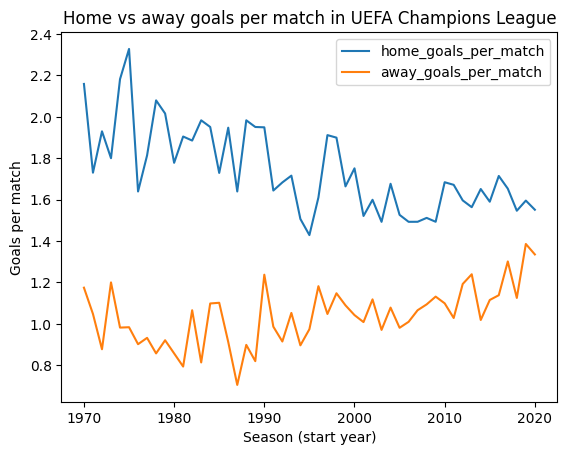

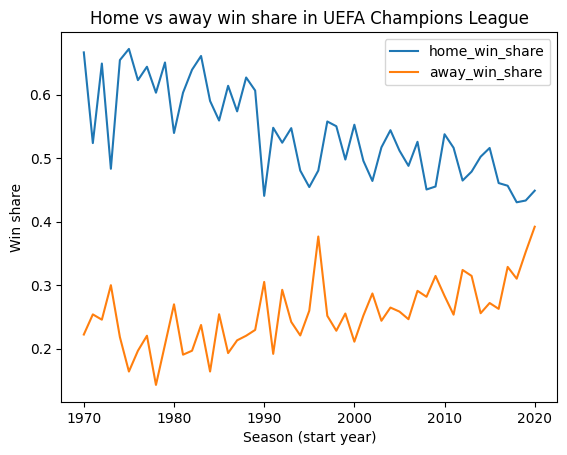

In [8]:
# Work off the full matches frame loaded earlier
home_df = df.copy()

# Ensure season_start is numeric
home_df["season_start"] = home_df["season_start"].astype(int)

# Make sure the goal / penalty columns exist and are numeric
for col in ["ft1", "ft2", "et1", "et2", "pen1", "pen2"]:
    if col not in home_df.columns:
        home_df[col] = 0
    home_df[col] = pd.to_numeric(home_df[col], errors="coerce").fillna(0)

# Exclude matches that are not finished
home_df = home_df[home_df["status"] == "FINISHED"].copy()

# Goals by the home and away team
home_df["home_goals"] = home_df["et1"]
home_df["away_goals"] = home_df["et2"]

def match_result(row):
    """Return H (home win), A (away win) or D (draw).

    - Compare goals after regular + extra time.
    - If still level, use penalties (pen1/pen2) as a tiebreaker.
    """
    hg = row["home_goals"]
    ag = row["away_goals"]

    if hg > ag:
        return "H"
    if hg < ag:
        return "A"

    # include penalties if we have them
    p1 = row["pen1"]
    p2 = row["pen2"]

    if p1 > p2:
        return "H"
    if p2 > p1:
        return "A"

    return "D"

home_df["result"] = home_df.apply(match_result, axis=1)

# Aggregate per season_start
summary_by_season = (
    home_df
    .groupby("season_start")
    .agg(
        matches=("match_id", "count"),
        home_wins=("result", lambda s: (s == "H").sum()),
        draws=("result", lambda s: (s == "D").sum()),
        away_wins=("result", lambda s: (s == "A").sum()),
        home_goals=("home_goals", "sum"),
        away_goals=("away_goals", "sum"),
    )
)

summary_by_season["home_win_share"] = summary_by_season["home_wins"] / summary_by_season["matches"]
summary_by_season["away_win_share"] = summary_by_season["away_wins"] / summary_by_season["matches"]
summary_by_season["draw_share"] = summary_by_season["draws"] / summary_by_season["matches"]
summary_by_season["home_goals_per_match"] = summary_by_season["home_goals"] / summary_by_season["matches"]
summary_by_season["away_goals_per_match"] = summary_by_season["away_goals"] / summary_by_season["matches"]

# Focus on the period that roughly matches UEFA's communication
summary_1970_2020 = summary_by_season.loc[1970:2020].copy()

display(summary_1970_2020.head(10))

print("\nAverage over the 1970s (1970–1979):")
display(
    summary_1970_2020.loc[1970:1979, [
        "home_win_share",
        "away_win_share",
        "draw_share",
        "home_goals_per_match",
        "away_goals_per_match",
    ]].mean()
)

print("\nAverage over 2010–2020:")
display(
    summary_1970_2020.loc[2010:2020, [
        "home_win_share",
        "away_win_share",
        "draw_share",
        "home_goals_per_match",
        "away_goals_per_match",
    ]].mean()
)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
summary_1970_2020[["home_goals_per_match", "away_goals_per_match"]].plot(ax=ax)
ax.set_xlabel("Season (start year)")
ax.set_ylabel("Goals per match")
ax.set_title("Home vs away goals per match in UEFA Champions League")
plt.show()

fig2, ax2 = plt.subplots()
summary_1970_2020[["home_win_share", "away_win_share"]].plot(ax=ax2)
ax2.set_xlabel("Season (start year)")
ax2.set_ylabel("Win share")
ax2.set_title("Home vs away win share in UEFA Champions League")
plt.show()


## Checking UEFA's home/away goals per match figures

UEFA state that, in men's competitions, there has been a long term trend in
the **average number of goals per match scored at home and away**, from
approximately **2.02 / 0.95** to **1.58 / 1.15** (home / away).

Here we compare:
- **Champions League / European Cup** data for the **1970s (1970–1979)**,
- Against the period **2010–2020**,

using the season level aggregates already computed in `summary_by_season` /
`summary_1970_2020`.


In [9]:
summary_1970_2020 = summary_by_season.loc[1970:2020].copy()

# decade averages
_1970s = summary_1970_2020.loc[1970:1979, [
    "home_goals_per_match",
    "away_goals_per_match",
]].mean()

_2010_2020 = summary_1970_2020.loc[2010:2020, [
    "home_goals_per_match",
    "away_goals_per_match",
]].mean()

# UEFA's values
uefa_early_home, uefa_early_away = 2.02, 0.95
uefa_late_home, uefa_late_away = 1.58, 1.15

comparison = pd.DataFrame(
    {
        "home_goals_per_match": [_1970s["home_goals_per_match"], _2010_2020["home_goals_per_match"]],
        "uefa_home_goals_per_match": [uefa_early_home, uefa_late_home],
        "diff_home": [
            _1970s["home_goals_per_match"] - uefa_early_home,
            _2010_2020["home_goals_per_match"] - uefa_late_home,
        ],
        "away_goals_per_match": [_1970s["away_goals_per_match"], _2010_2020["away_goals_per_match"]],
        "uefa_away_goals_per_match": [uefa_early_away, uefa_late_away],
        "diff_away": [
            _1970s["away_goals_per_match"] - uefa_early_away,
            _2010_2020["away_goals_per_match"] - uefa_late_away,
        ],
    },
    index=["1970s (1970–1979)", "2010–2020"],
)

print("Comparison of home/away goals per match (CL/EC data vs UEFA headline values)")
display(comparison)


Comparison of home/away goals per match (CL/EC data vs UEFA headline values)


,home_goals_per_match,uefa_home_goals_per_match,diff_home,away_goals_per_match,uefa_away_goals_per_match,diff_away
1970s (1970–1979),1.967654,2.02,-0.052346,0.987646,0.95,0.037646
2010–2020,1.619627,1.58,0.039627,1.179866,1.15,0.029866


## Conclusion

Our analysis largely reproduces the descriptive numbers UEFA cite in their article:
home advantage in men’s competitions has clearly declined over the decades and away teams now score more and win more often than they used to.

However, the **fairness based arguments** used to justify abolishing the away‑goals rule are not strongly supported by our data:

- Over two legs, once we control for seeding in the Champions League round of 16, the probability that the team with the **second leg at home** advances is now very close to **50/50**. The tie‑level advantage of playing the return leg at home has shrunk, but it has not disappeared.
- In **extra time**, the team playing the **second leg at home** actually wins more often than the second‑leg away team. The dramatic scenario UEFA describe the home side in extra time being “obliged to score twice” once it concedes occurs very rarely and does not drive qualification in more than a tiny fraction of ties. In this sense, the *practical* unfairness of the rule in extra time appears minimal in our sample.
- The claim that the rule “dissuades home teams – especially in first legs – from attacking” cannot be tested properly with this dataset. We only observe final scores, not tactical intent or chance creation, and we have not yet isolated first‑leg home teams in a time‑trend analysis. This may well be the most important remaining argument for abolishing the rule, but it requires a different type of data and a focused study, ideally on more recent seasons.

In summary, our work confirms UEFA’s description of how home and away performance have converged over time, but it offers little empirical support for the idea that the away‑goals rule is materially unfair in terms of who qualifies. The open question is whether it genuinely suppresses attacking play by home teams in first legs, which should be investigated separately, for example by analysing newer seasons with richer event data (shots, expected goals, etc.).
